### Import the necessary program libraries

In [1]:
import pandas as pd
import plotly.graph_objects as go
from classes import KMeansClusterMain, BaseLoader
import plotly.express as px
from funcs import to_float, get_density, get_color
from matplotlib.colors import Normalize
from matplotlib import cm
import matplotlib.colors as mcolors

### Select the data

In [4]:
data_manager = BaseLoader()
symbol = data_manager.choose_id()
print(symbol)

Please choose the symbol or name from the index which should be analysed.
symbol AMZN: Amazon
symbol BKNG: Booking Holdings
symbol DASH: DoorDash
symbol HD: Home Depot
symbol LOW: Lowe’s
symbol MCD: McDonald's
symbol NKE: Nike
symbol SBUX: Starbucks
symbol TJX: TJX Companies
symbol TSLA: Tesla
You can typ 'q' to quit.


symbol:  Home


There is no Home in the database, please try another!


symbol:  LOW


LOW


### Prepare the data and make some cleaning

In [7]:
df_stock = pd.read_csv(csv_path)
df_stock["Datum"] = pd.to_datetime(df_stock["Datum"], dayfirst=True)
df_stock = df_stock.sort_values('Datum').reset_index(drop=True)
df_stock = df_stock.drop(df_stock.columns[-2:], axis=1)
df_stock['Zuletzt'] = df_stock['Zuletzt'].apply(to_float)
df_stock['Hoch'] = df_stock['Hoch'].apply(to_float)
df_stock['Tief'] = df_stock['Tief'].apply(to_float)
df_stock['Eröffn.'] = df_stock['Eröffn.'].apply(to_float)
df_stock['volatility_max'] = (df_stock['Hoch'] - df_stock['Tief']).rolling(21).max()
df_stock['volatility_mean'] = (df_stock['Hoch'] - df_stock['Tief']).rolling(21).mean()


### The Mean Volatility for the cut off the timeframe 

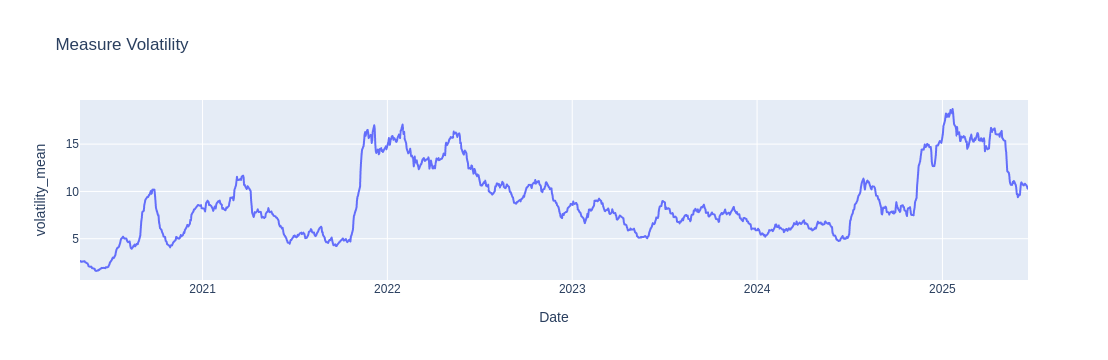

In [11]:
fig = px.line(df_stock, x="Datum", y="volatility_mean", title="Measure Volatility",labels={"Datum": "Date"})
fig.show()

### The Max Volatility for the entry into the market

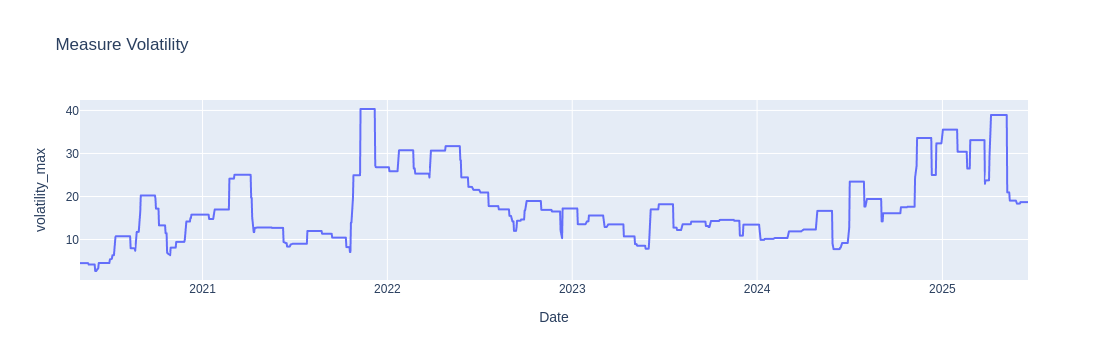

In [10]:
fig = px.line(df_stock, x="Datum", y="volatility_max", title="Measure Volatility",labels={"Datum": "Date"})
fig.show()

### Select Date to focus the window

In [9]:
df_stock = df_stock[df_stock['Datum'] >= '2020-05-01']
print(df_stock.head())
print(df_stock.tail())

          Datum  Zuletzt  Eröffn.   Hoch   Tief  volatility_max  \
1335 2020-05-04    45.13    43.33  45.71  41.53             4.5   
1336 2020-05-05    47.91    47.73  48.97  46.82             4.5   
1337 2020-05-06    47.77    48.06  48.47  47.13             4.5   
1338 2020-05-07    48.01    48.49  49.13  47.33             4.5   
1339 2020-05-08    50.24    48.62  50.33  48.33             4.5   

      volatility_mean  
1335         2.582857  
1336         2.638095  
1337         2.609048  
1338         2.553810  
1339         2.584762  
          Datum  Zuletzt  Eröffn.    Hoch    Tief  volatility_max  \
2639 2025-06-13   276.45   270.35  278.00  268.70            18.7   
2640 2025-06-16   284.75   285.50  287.50  281.60            18.7   
2641 2025-06-17   276.70   283.25  283.70  276.70            18.7   
2642 2025-06-18   283.15   275.50  283.15  274.40            18.7   
2643 2025-06-19   277.00   277.75  279.00  275.35            18.7   

      volatility_mean  
2639        10

### Compute the main process

1. Calculate the percentage change on daily bases

2. Within the percentage change datapoints calculate the clusters with the help of the KMeans-Clustering-Algorithm

3. Calculate the necessary density column with the cluster labels and sum up the kmeans centroids with that and save them

In [12]:
# Compute the percentage change
df_stock["perc_change"] = df_stock["Zuletzt"].pct_change()
df_stock.dropna(inplace=True)
df_stock = df_stock[df_stock['perc_change'] != 0.0]

# Here comes KMeans
datapoints = df_stock["perc_change"].to_list()
kmeans = KMeansClusterMain(3)
kmeans.fit(datapoints) 

# Assign the clusters
df_stock["cluster"] = kmeans.labels
df_stock["cluster"] = pd.to_numeric(df_stock["cluster"])

# Get the density for the colormap
df_stock["density"] = df_stock["cluster"].rolling(21).apply(get_density, kwargs={'orig_density': kmeans.centroids})

# cluster_str needed for kmeans volatility cluster graph.
df_stock["cluster_str"] = df_stock.cluster.astype(str)
df_stock['perc_change'] = df_stock['perc_change'] * 100

print(df_stock.isna().any())
print(df_stock.info())

Datum              False
Zuletzt            False
Eröffn.            False
Hoch               False
Tief               False
volatility_max     False
volatility_mean    False
perc_change        False
cluster            False
density             True
cluster_str        False
dtype: bool
<class 'pandas.core.frame.DataFrame'>
Index: 1305 entries, 1336 to 2643
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   Datum            1305 non-null   datetime64[ns]
 1   Zuletzt          1305 non-null   float64       
 2   Eröffn.          1305 non-null   float64       
 3   Hoch             1305 non-null   float64       
 4   Tief             1305 non-null   float64       
 5   volatility_max   1305 non-null   float64       
 6   volatility_mean  1305 non-null   float64       
 7   perc_change      1305 non-null   float64       
 8   cluster          1305 non-null   int64         
 9   density          128

### Need it for further processing of the boundaries and the coloring

In [13]:
describe_ser = df_stock["density"].describe()
upper_limit = describe_ser["mean"] + (describe_ser["std"] * 2)
lower_limit = describe_ser["mean"] - (describe_ser["std"] * 2)
print(describe_ser)

count    1285.000000
mean        0.043112
std         0.175673
min        -0.482962
25%        -0.075690
50%         0.030720
75%         0.154548
max         0.509091
Name: density, dtype: float64


### Checking the volatility in percentage daily changes

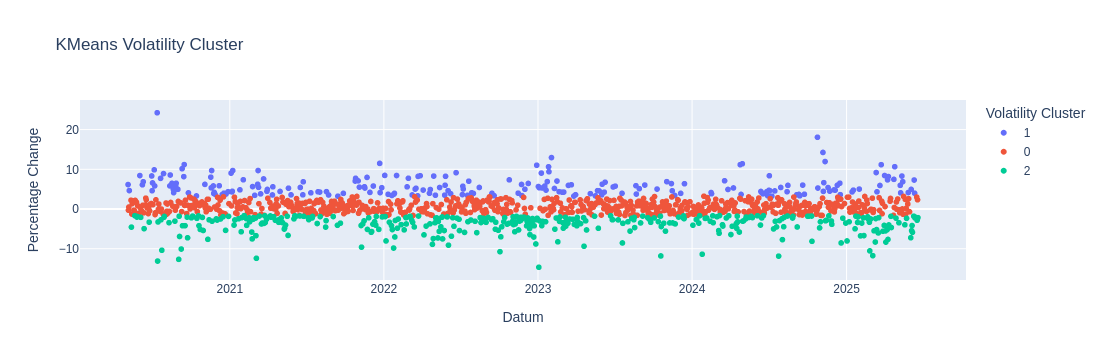

In [14]:
fig = px.scatter(df_stock, x="Datum", y="perc_change", color="cluster_str", 
                 title="KMeans Volatility Cluster", 
                 labels={"date": "Date", "perc_change": "Percentage Change", 
                         "cluster_str": "Volatility Cluster",})
fig.show()

In [15]:
# Need it for the sell order
df_stock.loc[df_stock['cluster'] == 1]['perc_change'].describe()


count    225.000000
mean       5.897898
std        2.594733
min        3.235294
25%        4.129754
50%        5.288821
75%        6.882169
max       24.241329
Name: perc_change, dtype: float64

### Show the boundaries

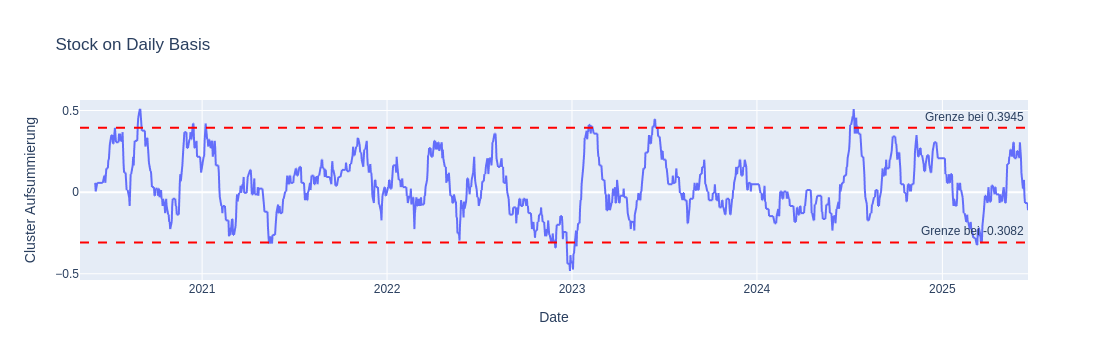

In [16]:
fig = px.line(df_stock, x="Datum", y="density", title="Stock on Daily Basis",
                  labels={"Datum": "Date", "density": "Cluster Aufsummierung"})

fig.add_hline(y=upper_limit, line_dash="dash", line_color="red", annotation_text=f"Grenze bei {round(upper_limit,4)}")
fig.add_hline(y=lower_limit, line_dash="dash", line_color="red", annotation_text=f"Grenze bei {round(lower_limit,4)}")


fig.show()

### Color the price history according to the column density

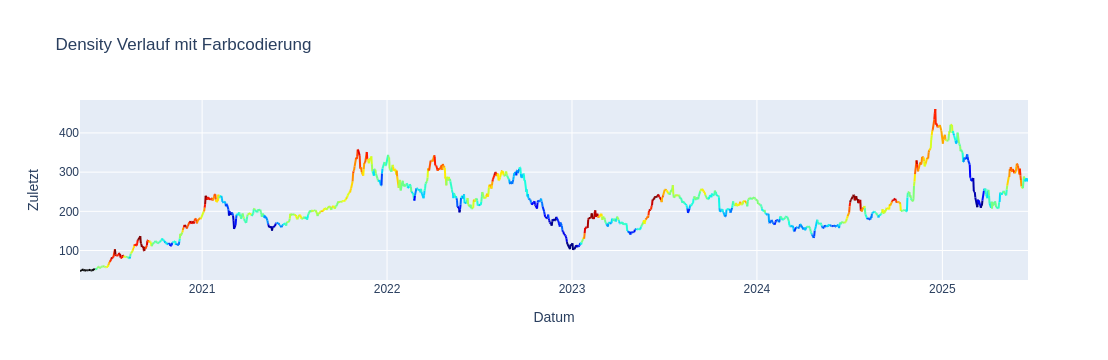

Untere Grenze (vmin): -0.31
Obere Grenze (vmax): 0.39
Mittelwert: 0.04


In [17]:
# Statistical limits for clipping
vmin = lower_limit
vmax = upper_limit

# Create normalization
norm = Normalize(vmin=vmin, vmax=vmax, clip=True)

# Create plotly-figure
fig = go.Figure()

# Draw line segments with colors based on density
for i in range(len(df_stock) - 1):
    density_value = df_stock["density"].iloc[i]
    color = get_color(density_value, norm)
    
    fig.add_trace(go.Scatter(
        x=df_stock["Datum"].iloc[i:i+2],  # Zwei Punkte verbinden
        y=df_stock["Zuletzt"].iloc[i:i+2],
        mode="lines",
        line=dict(color=color, width=2),
        showlegend=False,
    ))

# Adjust layout
fig.update_layout(
    title="Density Verlauf mit Farbcodierung",
    xaxis_title="Datum",
    yaxis_title="Zuletzt",
    # Add colorbar
    coloraxis=dict(
        colorbar=dict(
            title="Density",
            ticktext=["Niedrig (Blau)", "Neutral (Grün)", "Hoch (Rot)"],
            tickvals=[vmin, (vmin+vmax)/2, vmax]
        ),
        colorscale="jet",
        cmin=vmin,
        cmax=vmax
    )
)

fig.show()

# Optional: Ausgabe der Grenzwerte zur Kontrolle
print(f"Untere Grenze (vmin): {vmin:.2f}")
print(f"Obere Grenze (vmax): {vmax:.2f}")
print(f"Mittelwert: {describe_ser['mean']:.2f}")